# ConvNet implementation

### Data Preprocessing

In [9]:
import os
import cv2
import numpy as np
from tqdm import tqdm # throw info during iteration

REBUILD_DATA = False # Change to True for generating the numpy file with the preprocessed data!

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "kagglecatsanddogs_3367a/PetImages/Cat"
    DOGS = "kagglecatsanddogs_3367a/PetImages/Dog"
    LABELS = {CATS:0, DOGS:1}
    training_data = []
    catcount = 0
    dogcount = 0
    errors = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)            
            for f in tqdm(os.listdir(label)): # iterate each file in the specific directory
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    self.errors += 1
                    #print(e) 
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print(f"Cats: {self.catcount}")
        print(f"Dogs: {self.dogcount}")
        print(f"Errors: {self.errors}")

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

### Loading preprocessed data 

In [10]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [11]:
print(len(training_data))

24946


In [12]:
print(training_data[0]) # image and label

[array([[116, 115,  76, ..., 165, 177, 173],
        [116, 115,  79, ..., 164, 177, 173],
        [116, 115,  77, ..., 165, 176, 172],
        ...,
        [101,  90, 101, ..., 100,  99,  98],
        [ 92,  91,  88, ..., 103, 102, 116],
        [ 94,  94,  98, ...,  99, 100, 103]], dtype=uint8) array([1., 0.])]


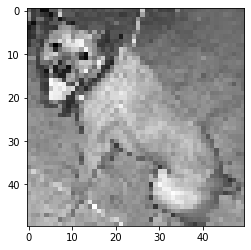

This is a DOG


In [14]:
import matplotlib.pyplot as plt 

N = 35
img = training_data[N,0]
ohe = training_data[N,1]
if ohe[0] == 1:
    label = "CAT"
else: 
    label = "DOG"

plt.imshow(img, cmap = 'gray')
plt.show()
print(f'This is a {label}')

## Data split

In [15]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X), len(test_X))

2494
22452 2494


## Is CUDA available ?

In [16]:
torch.cuda.is_available()

True

### Assigning GPU to device

In [17]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("running on the GPU :)")
else: 
    device = torch.device('cpu')
    print("running on the CPU :(")

running on the GPU :)


### Number of GPUs

In [19]:
torch.cuda.device_count()

1

# Transfer th DNN to the GPU

In [20]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

device = torch.device('cuda:0')

class Net(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.30)

        self.fc1 = nn.Linear(22*22*128, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        #print(f'initial dim = {x.shape}')

        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        #print(f'after first conv, dim = {x.shape}')

        x = self.conv2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        #print(f'after second conv, dim = {x.shape}')


        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)

        #print(f'after third conv, dim = {x.shape}')


        x = torch.flatten(x,1)
        
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        output = F.softmax(x, dim=1)
        
        return output

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=61952, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

## Training

In [22]:
import torch.optim as optim
import os
import cv2
import numpy as np
from tqdm import tqdm # throw info during iteration

BATCH_SIZE = 100
EPOCHS = 1

def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.MSELoss()

    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
            #print(f"{i}:{i+BATCH_SIZE}")
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()

            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    # Does the update

        print(f"Epoch: {epoch}. Loss: {loss}")

train(net)

100%|██████████| 225/225 [00:12<00:00, 18.60it/s]


Epoch: 0. Loss: 0.23571285605430603


## Testing 

In [23]:
def test(net):    
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy: ", round(correct/total, 3))

test(net)

100%|██████████| 2494/2494 [00:02<00:00, 1158.50it/s]

Accuracy:  0.619


In [ ]:
0.718